# Setup gemini API key and ChromaDB

In [1]:
from dotenv import load_dotenv
import os

load_dotenv()
api_key = os.getenv("GOOGLE_API_KEY")


In [2]:
from google import genai
import chromadb.utils.embedding_functions as embedding_functions
import chromadb


chroma_client = chromadb.PersistentClient(path="db/", settings=chromadb.Settings(allow_reset=True))

# Use the latest model: models/text-embedding-004
google_ef  = embedding_functions.GoogleGenerativeAiEmbeddingFunction(
    api_key=api_key,
    model_name="models/text-embedding-004",
    task_type="RETRIEVAL_DOCUMENT"
)

client = genai.Client(api_key=api_key)

d:\AAST\9th semester\Image Processing and Pattern Recognition\assignments\RAG\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
collection = chroma_client.get_or_create_collection(name="mkdocsGPT", embedding_function=google_ef)


# Split the markdown files into chunks

splitting is done on header **REASON**

In [23]:
from langchain_text_splitters import MarkdownHeaderTextSplitter

headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
]

splitter = MarkdownHeaderTextSplitter(
    headers_to_split_on=headers_to_split_on
)


In [24]:
import os
import pickle
from langchain_community.document_loaders import TextLoader
from tqdm import tqdm

path = "mkdocs/docs/user-guide"

all_texts = []
all_metadatas = []
all_ids = []


for md_file in tqdm(os.listdir(path), desc="Loading Markdown files"):
    if not md_file.endswith(".md"):
        continue
    loader = TextLoader(f"{path}/{md_file}", encoding="utf-8")
    docs = loader.load()
    chunks = splitter.split_text(docs[0].page_content)

    all_texts.extend([c.page_content for c in chunks])

    for c in chunks:
        meta = c.metadata.copy() 
        meta["source"] = md_file
        all_metadatas.append(meta)

    all_ids.extend([
        f"{os.path.splitext(md_file)[0]}-c{i}"
        for i, _ in enumerate(chunks)
    ])

# Save to file
with open("split_data.pkl", "wb") as f:
    pickle.dump((all_texts, all_metadatas, all_ids), f)

print("✅ Data saved to split_data.pkl")

Loading Markdown files: 100%|██████████| 9/9 [00:00<00:00, 966.18it/s]

Loading Markdown files: 100%|██████████| 9/9 [00:00<00:00, 966.18it/s]

✅ Data saved to split_data.pkl


# Load chunks

In [6]:
import pickle

# === Load split data ===
with open("split_data.pkl", "rb") as f:
    all_texts, all_metadatas, all_ids = pickle.load(f)
# === Dynamic thread and batch settings ===
print(f"✅ Loaded {len(all_texts)} chunks.")
NUM_WORKERS = 4
BATCH_SIZE = 30
total = len(all_texts)


✅ Loaded 74 chunks.


In [7]:
all_texts[2], all_metadatas[2], all_ids[2]

("A clone of the default theme used by the [Read the Docs] service, which offers\nthe same restricted feature set as its parent theme. Like its parent theme, only\ntwo levels of navigation are supported.  \n![ReadTheDocs](../img/readthedocs.png)  \nIn addition to the default [theme configuration options][theme], the `readthedocs`\ntheme supports the following options:  \n*   **`highlightjs`**: Enables highlighting of source code in code blocks using\nthe [highlight.js] JavaScript library. Default: `True`.  \n*   **`hljs_languages`**: By default, highlight.js only supports 23 common\nlanguages. List additional languages here to include support for them.  \n```yaml\ntheme:\nname: readthedocs\nhighlightjs: true\nhljs_languages:\n- yaml\n- rust\n```  \n*   **`analytics`**: Defines configuration options for an analytics service.  \n*   **`gtag`**: To enable Google Analytics, set to a Google Analytics v4\ntracking ID, which uses the `G-` format. See Google's documentation to\n[Set up Analyti

# Clean chunks 

In [8]:
import re

def clean_chunk_content(text):
    """
    Applies cleaning rules to Markdown text specifically for MkDocs.
    """
    # 1. Remove YAML Frontmatter (--- ... --- at the start)
    text = re.sub(r'^---\n.*?\n---\n', '', text, flags=re.DOTALL)

    # 2. Normalize Admonitions (MkDocs specific syntax)
    # Converts: !!! note "Important Title" -> **Note: Important Title**
    def replace_admonition(match):
        type_name = match.group(1).capitalize()
        title = match.group(2)
        if title:
            title = title.strip('"\'')
            return f"\n**{type_name}: {title}**\n"
        return f"\n**{type_name}**\n"
    
    text = re.sub(r'!!!\s+(\w+)(?:\s+(".*?"))?', replace_admonition, text)

    # 3. Remove MkDocs Content Tabs (e.g., === "Tab Title")
    # These are structural and often add noise to the embedding
    text = re.sub(r'^[ \t]*===\s+".*?"\s*$', '', text, flags=re.MULTILINE)

    # 4. Simplify Links and Images
    # Images: ![Alt Text](url) -> Alt Text
    text = re.sub(r'!\[([^\]]*)\]\([^)]+\)', r'\1', text)
    # Links: [Link Text](url) -> Link Text
    text = re.sub(r'\[([^\]]+)\]\([^)]+\)', r'\1', text)

    # 5. Collapse excessive newlines
    text = re.sub(r'\n{3,}', '\n\n', text)

    # 6. Strip leading/trailing whitespace
    text = text.strip()

    return text

In [9]:
cleaned_texts = []
cleaned_metadatas = []
cleaned_ids = []

for original_text, metadata, id in zip(all_texts, all_metadatas, all_ids): 
    cleaned_text = clean_chunk_content(original_text)
    
    # Only keep the chunk if it still has content after cleaning
    if len(cleaned_text) > 10: 
        cleaned_texts.append(cleaned_text) # Fixed: Append the CLEANED text
        cleaned_metadatas.append(metadata)
        cleaned_ids.append(id)


print(f"Cleaning complete.")
print(f"Original chunks: {len(all_texts)}")
print(f"Cleaned chunks:  {len(cleaned_texts)}")

Cleaning complete.
Original chunks: 74
Cleaned chunks:  74


In [10]:
all_texts[2], cleaned_texts[2]

("A clone of the default theme used by the [Read the Docs] service, which offers\nthe same restricted feature set as its parent theme. Like its parent theme, only\ntwo levels of navigation are supported.  \n![ReadTheDocs](../img/readthedocs.png)  \nIn addition to the default [theme configuration options][theme], the `readthedocs`\ntheme supports the following options:  \n*   **`highlightjs`**: Enables highlighting of source code in code blocks using\nthe [highlight.js] JavaScript library. Default: `True`.  \n*   **`hljs_languages`**: By default, highlight.js only supports 23 common\nlanguages. List additional languages here to include support for them.  \n```yaml\ntheme:\nname: readthedocs\nhighlightjs: true\nhljs_languages:\n- yaml\n- rust\n```  \n*   **`analytics`**: Defines configuration options for an analytics service.  \n*   **`gtag`**: To enable Google Analytics, set to a Google Analytics v4\ntracking ID, which uses the `G-` format. See Google's documentation to\n[Set up Analyti

# Embed and add to ChromaDB

In [11]:
import time
def embed_and_insert(start_idx: int, end_idx: int):
    texts = cleaned_texts[start_idx:end_idx]
    metadatas = cleaned_metadatas[start_idx:end_idx]
    ids = cleaned_ids[start_idx:end_idx]
    
    print(f"✅ Processing {start_idx} to {end_idx} ({len(texts)} chunks)")

    # Check which IDs already exist in the collection
    try:
        existing = collection.get(ids=ids)
        existing_ids = set(existing["ids"])
    except Exception as e:
        print(f"⚠️ Could not fetch existing IDs: {e}")
        existing_ids = set()

    # Filter out already existing IDs
    filtered_texts, filtered_metadatas, filtered_ids = [], [], []
    for t, m, i in zip(texts, metadatas, ids):
        if i not in existing_ids:
            filtered_texts.append(t)
            filtered_metadatas.append(m)
            filtered_ids.append(i)

    if not filtered_ids:
        print("⏩ All IDs already exist. Skipping batch.")
        return

    try:
        collection.add(documents=filtered_texts, metadatas=filtered_metadatas, ids=filtered_ids)
    except Exception as e:
        print(f"❌ Retry after error: {e}")
        time.sleep(60)
        try:
            collection.add(documents=filtered_texts, metadatas=filtered_metadatas, ids=filtered_ids)
        except Exception as e:
            print(f"❌ Permanent failure: {e}")
    
    time.sleep(4)

In [12]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

# Fix: Use the length of the CLEANED list, not the original list
total = len(cleaned_texts)
futures = []

print(f"🚀 Starting embedding for {total} chunks...")

with ThreadPoolExecutor(max_workers=NUM_WORKERS) as executor:
    for i in range(0, total, BATCH_SIZE):
        futures.append(executor.submit(embed_and_insert, i, min(i + BATCH_SIZE, total)))

    for _ in tqdm(as_completed(futures), total=len(futures), desc="Embedding Chunks", unit="batch"):
        try:
            _.result()
        except Exception as e:
            print(f"❌ Thread failed: {e}")

print("✅ Indexing completed.")

🚀 Starting embedding for 74 chunks...
✅ Processing 0 to 30 (30 chunks)
✅ Processing 30 to 60 (30 chunks)
✅ Processing 60 to 74 (14 chunks)


Embedding Chunks: 100%|██████████| 3/3 [00:13<00:00,  4.39s/batch]

✅ Indexing completed.


In [13]:
collection.count()

74

In [14]:
collection.peek()

{'ids': ['localizing-your-theme-c1',
  'localizing-your-theme-c2',
  'localizing-your-theme-c3',
  'localizing-your-theme-c4',
  'README-c0',
  'writing-your-docs-c0',
  'writing-your-docs-c1',
  'writing-your-docs-c2',
  'writing-your-docs-c3',
  'writing-your-docs-c4'],
 'embeddings': array([[ 0.00012513,  0.00843986, -0.02156573, ...,  0.00869281,
          0.03570561,  0.03028397],
        [ 0.02699316,  0.03347502, -0.02179236, ..., -0.02274634,
          0.06230333,  0.00815704],
        [ 0.00802136, -0.00029996, -0.01184476, ...,  0.0080455 ,
          0.0374604 ,  0.00800175],
        ...,
        [ 0.01411741, -0.01387761,  0.03326308, ..., -0.01930273,
          0.03213229,  0.03717705],
        [ 0.02691044,  0.00673791, -0.03426386, ...,  0.01478824,
          0.00263057,  0.04788117],
        [ 0.01214734, -0.01043298, -0.02802657, ..., -0.03119565,
          0.05234153,  0.00082624]], shape=(10, 768)),
 'documents': ["For theme localization to work, you must use a theme 

In [17]:
collection.query(
    query_texts=["How to choose a theme in MkDocs?"],
    n_results=10,
)

{'ids': [['choosing-your-theme-c0',
   'README-c0',
   'choosing-your-theme-c3',
   'localizing-your-theme-c3',
   'configuration-c23',
   'configuration-c18',
   'localizing-your-theme-c2',
   'localizing-your-theme-c0',
   'localizing-your-theme-c1',
   'customizing-your-theme-c1']],
 'embeddings': None,
 'documents': [['Selecting and configuring a theme.  \n---  \nMkDocs includes two built-in themes (mkdocs and\nreadthedocs), as documented below. However, many [third party\nthemes] are available to choose from as well.  \nTo choose a theme, set the [theme] configuration option in your `mkdocs.yml`\nconfig file.  \n```yaml\ntheme:\nname: readthedocs\n```',
   'Building Documentation with MkDocs  \n---  \nThe MkDocs User Guide provides documentation for users of MkDocs. See\n[Getting Started] for an introductory tutorial. You can jump directly to a\npage listed below, or use the *next* and *previous* buttons in the navigation\nbar at the top of the page to move through the documentati

# Filter out very short chunks

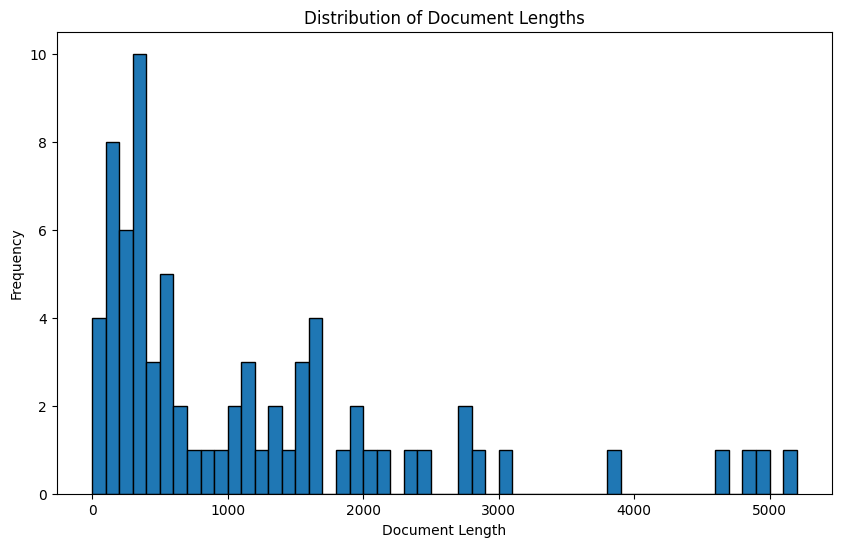

In [22]:
import matplotlib.pyplot as plt

documents = collection.peek(limit=total)

document_lengths = [len(doc) for doc in documents["documents"]]

plt.figure(figsize=(10, 6))
plt.hist(document_lengths, bins=range(0, max(document_lengths) + 10, 100), edgecolor='black')
plt.title("Distribution of Document Lengths")
plt.xlabel("Document Length")
plt.ylabel("Frequency")
plt.show()

In [23]:
import numpy as np

# Analyze the short chunks seen in the histogram
lengths = np.array(document_lengths)
threshold = 100
short_indices = np.where(lengths < threshold)[0]

print(f"🔍 Found {len(short_indices)} chunks shorter than {threshold} characters.")

print("\n--- Examples of Short Chunks (Potential Noise) ---")
for i in short_indices[:10]:
    doc = documents['documents'][i]
    print(f"[{len(doc)} chars]: {doc!r}")

🔍 Found 4 chunks shorter than 100 characters.

--- Examples of Short Chunks (Potential Noise) ---
[57 chars]: 'How to layout and write your Markdown source files.  \n---'
[71 chars]: 'A basic guide to deploying your docs to various hosting providers  \n---'
[23 chars]: 'A detailed guide.  \n---'
[52 chars]: 'Guide to all available configuration settings.  \n---'


In [24]:
print(f"Total documents before removal: {collection.count()}")

filtered_ids = [doc_id for doc_id, length in zip(documents["ids"], document_lengths) if length >= threshold]

try:
    collection.delete(ids=[doc_id for doc_id in documents["ids"] if doc_id not in filtered_ids])
    print(f"✅ Documents with length < {threshold} removed from the collection.")
except Exception as e:
    print(f"❌ Failed to remove documents: {e}")

print(f"Total documents after removal: {collection.count()}")



Total documents before removal: 74
✅ Documents with length < 100 removed from the collection.
Total documents after removal: 70


In [26]:
collection.query(
    query_texts=["What is repo url in MkDocs?"],
    n_results=10,
)

{'ids': [['configuration-c6',
   'configuration-c4',
   'deploying-your-docs-c8',
   'deploying-your-docs-c5',
   'configuration-c5',
   'README-c0',
   'configuration-c1',
   'writing-your-docs-c2',
   'configuration-c19',
   'configuration-c28']],
 'embeddings': None,
 'documents': [['The path from the base `repo_url` to the docs directory when directly viewing a\npage, accounting for specifics of the repository host (e.g. GitHub, Bitbucket,\netc), the branch, and the docs directory itself. MkDocs concatenates `repo_url`\nand `edit_uri`, and appends the input path of the page.  \nWhen set, and if your theme supports it, provides a link directly to the page in\nyour source repository. This makes it easier to find and edit the source for the\npage. If `repo_url` is not set, this option is ignored. On some themes, setting\nthis option may cause an edit link to be used in place of a repository link.\nOther themes may show both links.  \nThe `edit_uri` supports query (\'?\') and fragment 